In [44]:
import pandas as pd 
import os
import re

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objects as go
import cufflinks as cf 
cf.go_offline(connected=True)

# Data file description

- train_*.csv - contains traffic data. This a csv file where each row corresponds to a particular article and each column correspond to a particular date. Some entries are missing data. The page names contain the Wikipedia project (e.g. en.wikipedia.org), type of access (e.g. desktop) and type of agent (e.g. spider). In other words, each article name has the following format: 'name_project_access_agent' (e.g. 'AKB48_zh.wikipedia.org_all-access_spider').

- key_*.csv - gives the mapping between the page names and the shortened Id column used for prediction

In [2]:
DATA_PATH = "data"

In [5]:
traffic_data_list = [pd.read_csv(os.path.join(DATA_PATH, filename)) 
                   for filename in os.listdir(DATA_PATH) if "train" in filename]

df_traffic = pd.concat(traffic_data_list)
df_traffic = df_traffic.reset_index(drop=True)

In [6]:
key_list = [pd.read_csv(os.path.join(DATA_PATH, filename)) 
                   for filename in os.listdir(DATA_PATH) if "key" in filename]

df_key = pd.concat(key_list)
df_key = df_key.reset_index(drop=True)

# 데이터 모판만들기 
- 날짜별 데이터 빼기 
- 메타데이터 빼기
- 데이터 합치기

In [7]:
df_traffic_table = pd.melt(df_traffic, id_vars=['Page'], value_vars=df_traffic.columns[1:])
df_traffic_table.rename(columns={"variable":"date", "value":"count"}, inplace=True)

In [8]:
df_key.head(2).T 

,0,1
Page,007_スペクター_ja.wikipedia.org_all-access_all-agen...,007_スペクター_ja.wikipedia.org_all-access_all-agen...
Id,0b293039387a,7114389dd824


In [9]:
def get_date(page):
    return page.split("_")[-1]

df_key["date"] = df_key["Page"].map(get_date)

In [10]:
def get_new_name_without_date(page):
    return "_".join(page.split("_")[:-1])

df_key["Page"] = df_key["Page"].map(get_new_name_without_date)

In [11]:
len(df_traffic_table), len(df_key)

(232971178, 17697686)

In [12]:
df_key.head(2).T

,0,1
Page,007_スペクター_ja.wikipedia.org_all-access_all-agents,007_スペクター_ja.wikipedia.org_all-access_all-agents
Id,0b293039387a,7114389dd824
date,2017-09-13,2017-09-14


In [13]:
len(df_traffic_table["Page"].unique()), len(df_key["Page"].unique())

(145063, 145063)

In [14]:
df_all = pd.merge(df_traffic_table, df_key, how="left", left_on=["Page", "date"], right_on=["Page", "date"]) 
# del df_traffic_table
# del df_key
# del df_traffic

In [15]:
df_all.head(2).T 

,0,1
Page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider
date,2015-07-01,2015-07-01
count,18,11
Id,NaN,NaN


In [16]:
def get_language(page):
    res = re.search('[a-z][a-z].wikipedia.org',page)
    if res:
        return res[0][0:2]
    return 'na'

df_all["language"] = df_all.Page.map(get_language)

In [17]:
def get_aceess_type(page):
    for aceess_type in ["all-access", "desktop", "mobile-web"]:
        if aceess_type in page:
            return aceess_type
    return 'na'

df_all["access_type"] = df_all.Page.map(get_aceess_type)

In [18]:
def get_agent_type(page):
    for agent_type in ["all-agents", "spider"]:
        if agent_type in page:
            return agent_type
    return 'na'
df_all["agent_type"] = df_all.Page.map(get_agent_type)

In [19]:
df_all.head(2).T

,0,1
Page,2NE1_zh.wikipedia.org_all-access_spider,2PM_zh.wikipedia.org_all-access_spider
date,2015-07-01,2015-07-01
count,18,11
Id,NaN,NaN
language,zh,zh
access_type,all-access,all-access
agent_type,spider,spider


# EDA
## 가설 1: 언어별로 viewing 횟수의 차이가 존재하는가?

In [20]:
import plotly.express as px

In [21]:
df_chart = df_all.groupby("language")["count"].mean().reset_index()
fig = px.pie(df_chart, values='count', names='language')
fig.show()

In [ ]:
df_chart = df_all.groupby("access_type")["count"].mean().reset_index()
fig = px.pie(df_chart, values='count', names='access_type')
fig.show()
del df_chart

In [ ]:
df_chart = df_all.groupby("agent_type")["count"].mean().reset_index()
fig = px.pie(df_chart, values='count', names='agent_type')
fig.show()
del df_chart

In [ ]:
df_chart = df_all[df_all["language"] == "en"]
df_chart["count"].iplot(kind="hist")
del df_chart

In [ ]:
fig = px.violin(df_all, x="language", y="count", color="access_type", box=True, points="all")
fig.show()
del df_chart

In [22]:
df_all["wiki_type"] = df_all["language"] + "-" + df_all["agent_type"] + "-" + df_all["access_type"]

In [ ]:
df_chart = df_all.groupby("wiki_type")["count"].mean().reset_index()

In [26]:
fig = px.treemap(df_chart, path=["wiki_type"], values='count')
fig.show()
del df_chart

## 가설 2: 시계열적 특성이 국가별로 다를까?

In [31]:
df_all["date"] = pd.to_datetime(df_all["date"])

In [34]:
language_list = df_all["language"].unique().tolist()

In [ ]:
temp_df_list = []
for language in language_list:
    temp_df = df_all[df_all["language"] == language]
    temp_df = temp_df.groupby(["date"])["count"].mean().reset_index()
    temp_df["language"] = language
    temp_df_list.append(temp_df)
    del temp_df
df_chart = pd.concat(temp_df_list)

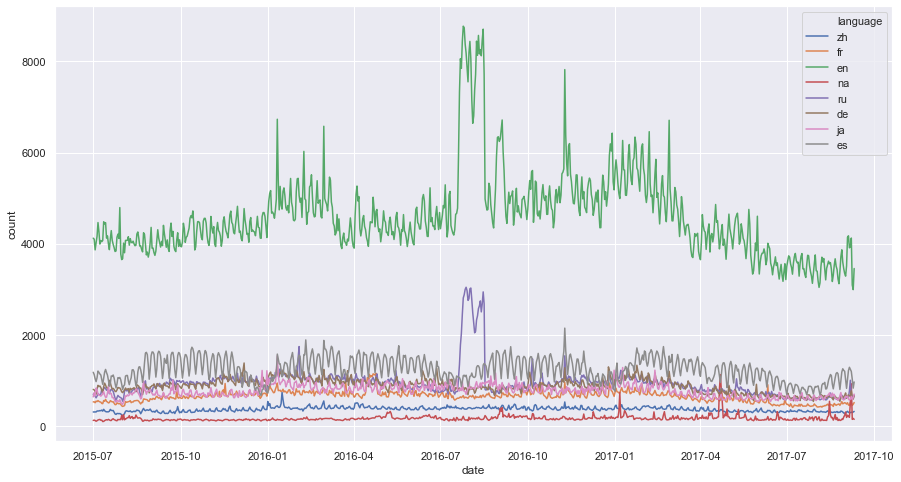

In [49]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="count",
                  hue="language",  data=df_chart) 

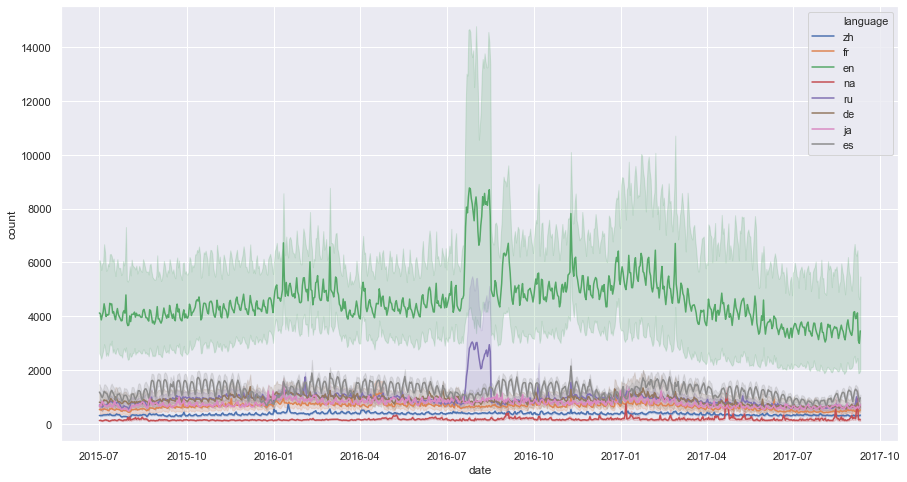

In [51]:
plt.figure(figsize=(15,8))
ax = sns.lineplot(x="date", y="count",
                  hue="language", data=df_all) 

In [52]:
### 2NE1 페이지의 count를 rolling을 사용하여 5일전 데이터를 하나의 instance에 연결하여라

In [56]:
df_2ne1 = df_all[df_all["Page"].str.contains("2NE1")]

In [57]:
df_2ne1

,Page,date,count,Id,language,access_type,agent_type,wiki_type
0,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,NaN,zh,all-access,spider,zh-spider-all-access
27965,2NE1_zh.wikipedia.org_all-access_all-agents,2015-07-01,785.0,NaN,zh,all-access,all-agents,zh-all-agents-all-access
60570,2NE1_zh.wikipedia.org_desktop_all-agents,2015-07-01,540.0,NaN,zh,desktop,all-agents,zh-all-agents-desktop
105110,2NE1_zh.wikipedia.org_mobile-web_all-agents,2015-07-01,238.0,NaN,zh,mobile-web,all-agents,zh-all-agents-mobile-web
145063,2NE1_zh.wikipedia.org_all-access_spider,2015-07-01,18.0,NaN,zh,all-access,spider,zh-spider-all-access
...,...,...,...,...,...,...,...,...
232786162,2NE1_zh.wikipedia.org_mobile-web_all-agents,2017-09-10,167.0,NaN,zh,mobile-web,all-agents,zh-all-agents-mobile-web
232826115,2NE1_zh.wikipedia.org_all-access_spider,2017-09-10,NaN,NaN,zh,all-access,spider,zh-spider-all-access
232854080,2NE1_zh.wikipedia.org_all-access_all-agents,2017-09-10,NaN,NaN,zh,all-access,all-agents,zh-all-agents-all-access
232886685,2NE1_zh.wikipedia.org_desktop_all-agents,2017-09-10,NaN,NaN,zh,desktop,all-agents,zh-all-agents-desktop
